# 机器学习练习 5 - 偏差和方差

本章代码涵盖了基于Python的解决方案，用于Coursera机器学习课程的第五个编程练习。 请参考[练习文本](ex5.pdf)了解详细的说明和公式。

代码修改并注释：黄海广，haiguang2000@qq.com

In [96]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [97]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [98]:
X, y, Xval, yval, Xtest, ytest = load_data()

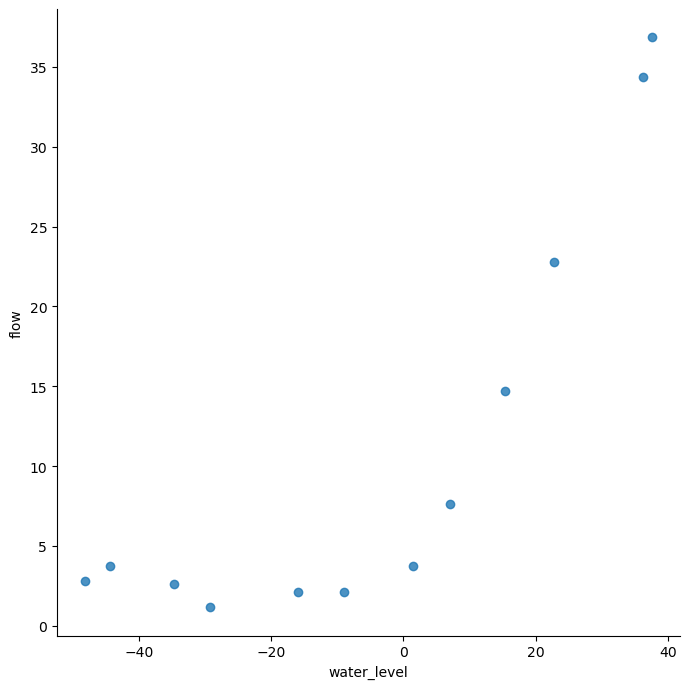

In [99]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot(x='water_level', y='flow', data=df, fit_reg=False, height=7)
plt.show()

In [100]:
X.shape, Xval.shape, Xtest.shape

((12,), (21,), (21,))

In [101]:
y.shape, yval.shape, ytest.shape

((12,), (21,), (21,))

In [102]:
# 在X前加一列1, X.shape = (12, 2)
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [103]:
X.shape, Xval.shape, Xtest.shape

((12, 2), (21, 2), (21, 2))

# 代价函数
<img style="float: left;" src="../img/linear_cost.png">

In [104]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)
    # print(inner.shape)
    # print(inner.T.shape)
    # print(np.sum(inner.T * inner))
    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner @ inner.T
    cost = square_sum / (2 * m)

    return cost[0, 0] if isinstance(cost, np.matrix) else cost

In [105]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

In [106]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

# 梯度
<img style="float: left;" src="../img/linear_gradient.png">

In [107]:
def gradient(theta, X, y):
    m = X.shape[0]
    term = X @ theta - y  # (m,n) @ (n, 1) -> (m, 1)

    inner = X.T @ term.T  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [108]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度
<img style="float: left;" src="../img/linear_reg_gradient.png">

In [109]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term
    grad = gradient(theta, X, y).flatten() + regularized_term
    # print(grad.shape)
    return grad

In [110]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

# 拟合数据
> 正则化项 $\lambda=0$

In [111]:
def linear_regression_np(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res


In [112]:
# theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

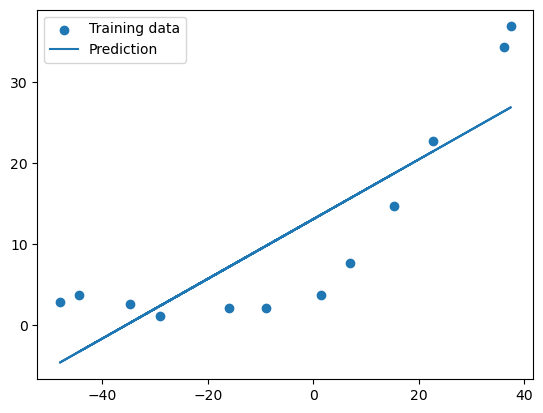

In [113]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [114]:
training_cost, cv_cost = [], []

1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

In [115]:
m = X.shape[0]
for i in range(1, m+1):
#     print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
#     print('tc={}, cv={}'.format(tc, cv))
    
    training_cost.append(tc)
    cv_cost.append(cv)

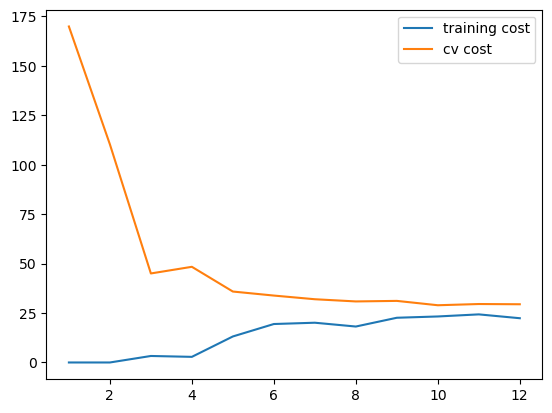

In [116]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

这个模型拟合不太好,<font color='red'>high bias</font>, **欠拟合了**

# 创建多项式特征

In [117]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return np.matrix(df.values) if as_ndarray else df


In [118]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [119]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = np.matrix(normalize_feature(df).values)

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [120]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [121]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. don't forget intercept term

In [122]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:2, :]

matrix([[ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
          0.30661792, -0.59087767,  0.3445158 , -0.50848117],
        [ 1.        , -0.80320484,  0.00125825, -0.24793699, -0.32702342,
          0.09339632, -0.43581761,  0.25541612, -0.44891249]])

# 画出学习曲线
> 首先，我们没有使用正则化，所以 $\lambda=0$

In [123]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)


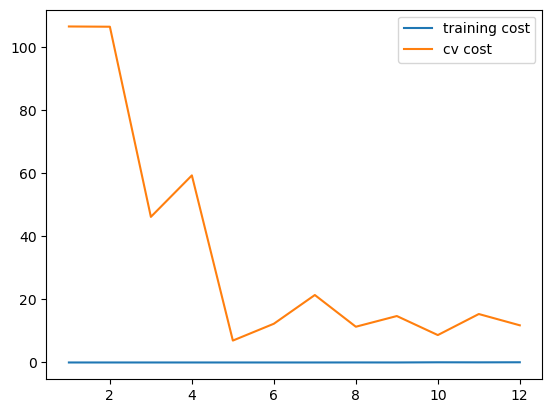

In [124]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

你可以看到训练的代价太低了，不真实. 这是 **过拟合**了

# try $\lambda=1$

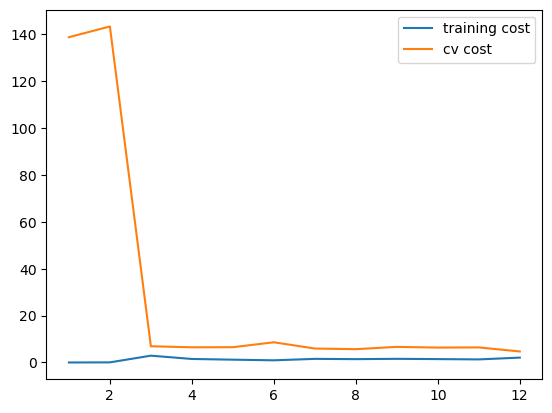

In [125]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()


训练代价增加了些，不再是0了。
也就是说我们减轻**过拟合**

# try $\lambda=100$

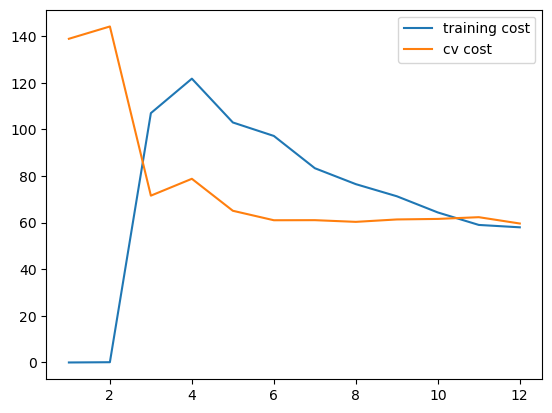

In [126]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

太多正则化了.  
变成 **欠拟合**状态

# 找到最佳的 $\lambda$

In [127]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [128]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

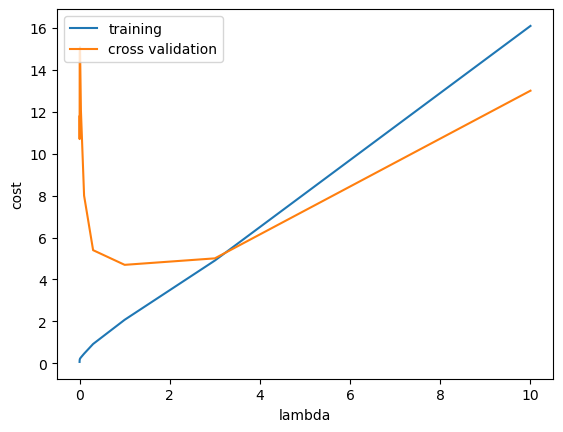

In [129]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [130]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]

1

In [131]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.19675303640657
test cost(l=0.001) = 11.047618788886734
test cost(l=0.003) = 11.265574861411878
test cost(l=0.01) = 10.880016515985872
test cost(l=0.03) = 10.023114468127915
test cost(l=0.1) = 8.632055393672232
test cost(l=0.3) = 7.3366117748019315
test cost(l=1) = 7.466278601947305
test cost(l=3) = 11.643928589149553
test cost(l=10) = 27.71508030799714


调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小